In [15]:
from apyori import apriori
from helper_functions import load_dataset
from typing import List, Tuple
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Loading the cleaned dataset

In [16]:
data: pd.DataFrame = None
transactions: List[List] = None
try:
    data = load_dataset('../data/assignment1_income_levels_cleaned.xlsx')
    transactions = data.astype(str).values.tolist()
except FileNotFoundError:
    print('File not found')

## 2) Search for Association Rules 

### Function to run the apriori algorithm

In [17]:
def run_apriori(folder: str, transactions: List[List], min_support: float, min_confidence: float, min_length: int=2, sorted_by_support: bool=True, consequence:List[str]=None):
    """
    Runs the apriori algorithm and writes the results (rules) to a txt file.
    :param folder: folder where the output file should be saved. If None, the file will not be saved
    :param transactions: dataset as a list of lists
    :param min_support: minimum support of relations
    :param min_confidence: minimum confidence of relations
    :param min_length: minimum number of items in a rule
    :param sorted_by_support: True if the apriori results should be sorted by support, False otherwise
    :param consequence: list of strings, so that the rules should have at least one of the strings as their consequence
    :return: dataframe with the rules
    """
    file_name: str = f'{folder}output_{min_support}_{min_confidence}_{min_length}.txt'
    results: List[Tuple] = list(apriori(transactions, min_support=min_support, min_confidence=min_confidence, min_length=min_length))
    nr_of_results: int = len(results) # this is the number of results returned by the apriori algorithm
    nr_of_real_results: int = 0 # this is the number of results that have minimum length = 2
    nr_of_rules: int = 0 # each result can have multiple rules, so here we count the total amount of association rules
    row_list = [] # list of dictionaries, where each dictionary represents a row in the (to be generated) dataframe
    file_txt = ""
    try:
        if sorted_by_support:
            results = sorted(results, key=lambda x: x.support, reverse=True) # this means our final output will be sorted by support too
        for rule in results:
            if len(rule.items) == 1:
                continue
            nr_of_real_results += 1
            to_write: str = f"Items: ({', '.join(rule.items)})\n" # for writing to txt file
            is_consequence_present: bool = False
            for i in range(0, len(rule.ordered_statistics)):
                antecedent: str = ', '.join(rule.ordered_statistics[i].items_base) # "left side" of the rule
                consequent: str = ', '.join(rule.ordered_statistics[i].items_add) # "right side" of the rule
                
                # skip rules with empty antecedent or consequent
                if len(antecedent) == 0 or len(consequent) == 0: 
                    continue
                    
                # if we are looking for a specific consequence, we skip the rules that do not have it
                if consequence is not None and consequent not in consequence:
                    continue
                is_consequence_present = True
                
                row_list.append({'antecedents': antecedent, 'consequents': consequent, 'support': rule.support, 'confidence': rule.ordered_statistics[i].confidence, 'lift': rule.ordered_statistics[i].lift})    
                
                support: str = str(rule.support)[:7] # float, so we need to convert it to string and limit the number of decimal places
                confidence: str = str(rule.ordered_statistics[i].confidence)[:7] # float, so we need to convert it to string and limit the number of decimal places
                lift: str = str(rule.ordered_statistics[i].lift)[:7] # float, so we need to convert it to string and limit the number of decimal places
            
                to_write += f"\t{antecedent} => {consequent} (support: {support}, confidence: {confidence}, lift: {lift})\n"
                nr_of_rules += 1
                
            to_write += '\n'
            if consequence is not None and not is_consequence_present:
                to_write = ''
            file_txt += to_write
            
        if folder is not None:
            with open(file_name, 'w') as file:
                file.write(f"Number of results: {nr_of_results}\n")
                file.write(f"Number of real results: {nr_of_real_results}\n") # this is the number of results that have minimum length = 2
                file.write(f"Number of total rules: {nr_of_rules}\n\n")
                file.write(file_txt)
            
        return pd.DataFrame(row_list, columns=['antecedents', 'consequents', 'support', 'confidence', 'lift'])                   
    except FileNotFoundError:
        print('File not found')
    except Exception as e:
        print(e)

### Function to generate a heatmap

In [18]:
def generate_heatmap(folder: str, rules: pd.DataFrame, heatmap_value: str='support', min_support: float=0.1, min_confidence: float=0.8):
    """
    Generates a heatmap from the rules dataframe, which are the resulting rules of the apriori algorithm.
    The dataframe should have the following columns in this order: antecedents, consequents, support, confidence, lift.
    Slightly based on https://medium.com/analytics-vidhya/market-basket-analysis-association-rule-mining-with-visualizations-cda24d537019
    :param folder: folder where the heatmap should be saved
    :param rules: dataframe with the rules
    :param heatmap_value: the value to base on in the heatmap
    :param min_support: minimum support that was used to generate the rules
    :param min_confidence: minimum confidence that was used to generate the rules
    """
    # Pivot the dataframe for heatmap
    heatmap_data = rules.pivot(index='antecedents', columns='consequents', values=heatmap_value)
    
    # Generate the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Association Rules {heatmap_value} Heatmap for min_support={min_support} and min_confidence={min_confidence} ')
    plt.xlabel('Consequents')
    plt.ylabel('Antecedents')
    plt.savefig(f'{folder}heatmap_{min_support}_{min_confidence}_{heatmap_value}.png')

### a) Running the apriori algorithm

Here, we play around with the algorithm and run it for different values for the "minimum support" and "minimum confidence" values.

In [19]:
%%capture
min_length: int = 2
sorted_by_support: bool = True # if True, the results will be sorted by support

supp_conf_values: List[Tuple] = [(0.2, 0.95), (0.6, 0.95), (0.8, 0.9), (0.8, 0.2), (0.6, 0.5), (0.2, 0.2)]
for min_support, min_confidence in supp_conf_values:
    rules = run_apriori("../output/a/", transactions, min_support, min_confidence, min_length, sorted_by_support)
    if 1 <= len(rules) < 250:
        generate_heatmap("../plots/assoc_rules/a/", rules, 'support', min_support, min_confidence)
        generate_heatmap("../plots/assoc_rules/a/", rules, 'confidence', min_support, min_confidence)

Below, we investigate the influence of minimum support and confidence on the number of association rules. We run the apriori algorithm for different values of minimum support with fixed minimum confidence (0.05) and for different values of minimum confidence with a fixed minimum support (0.05), and plot the number of rules for each case.

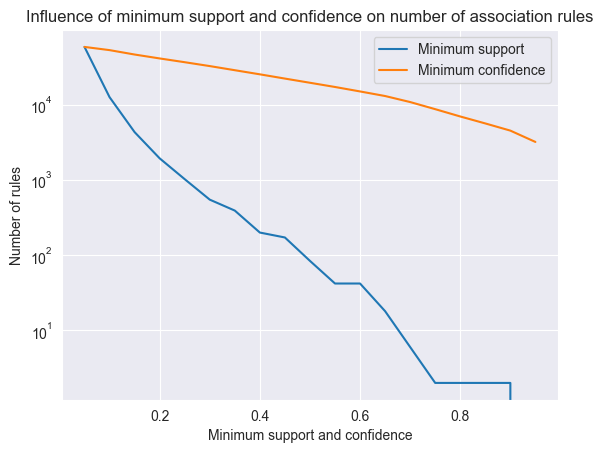

In [20]:
starting_sup_val = 0.05
starting_conf_val = 0.05

sup_val = starting_sup_val
conf_val = starting_conf_val

sup_rules = []
conf_rules = []

while sup_val < 1:
    rules = run_apriori(None, transactions, sup_val, starting_conf_val, min_length, sorted_by_support)
    sup_rules.append((sup_val, len(rules)))
    sup_val += 0.05 # increase the minimum support value by 0.05, so we will have around 20 iterations
    rules = run_apriori(None, transactions, starting_sup_val, conf_val, min_length, sorted_by_support)
    conf_rules.append((conf_val, len(rules)))
    conf_val += 0.05 # same here

x_sup, y_sup = zip(*sup_rules)
x_conf, y_conf = zip(*conf_rules)

# Plot the data
plt.plot(x_sup, y_sup, label='Minimum support')
plt.plot(x_conf, y_conf, label='Minimum confidence')
plt.xlabel('Minimum support and confidence')
plt.ylabel('Number of rules')
plt.title('Influence of minimum support and confidence on number of association rules')
plt.grid(True)
plt.yscale('log')
plt.legend()
plt.show()

### b) Running the apriori algorithm

Here, we extract rules that have “sex = Male” or “sex = Female” as their consequence. 

In [21]:
%%capture
supp_conf_values = [(0.1, 0.8), (0.6, 0.8), (0.9, 0.95), (0.8, 0.1)]
consequence: List[str] = ["Male", "Female"]

for min_support, min_confidence in supp_conf_values:
    rules = run_apriori("../output/b/", transactions, min_support, min_confidence, min_length, sorted_by_support, consequence) 
    if 1 <= len(rules) < 250:
        generate_heatmap("../plots/assoc_rules/b/", rules, 'support', min_support, min_confidence)
        generate_heatmap("../plots/assoc_rules/b/", rules, 'confidence', min_support, min_confidence)

In [22]:
%%capture
# splitting the data dataset into two separate datasets, one with only "Male" sex and another with only "Female" sex
data_male = data[data['sex'] == "Male"]
data_female = data[data['sex'] == "Female"]

transactions_male = data_male.astype(str).values.tolist()
transactions_female = data_female.astype(str).values.tolist()

supp_conf_values = [(0.2, 0.6)]
for min_support, min_confidence in supp_conf_values:
    rules_male = run_apriori("../output/b/split/male_", transactions_male, min_support, min_confidence, min_length, sorted_by_support, consequence) 
    rules_female = run_apriori("../output/b/split/female_", transactions_female, min_support, min_confidence, min_length, sorted_by_support, consequence) 
    if 1 <= len(rules_male) < 250:
        generate_heatmap("../plots/assoc_rules/b/split/male_", rules_male, 'support', min_support, min_confidence)
        generate_heatmap("../plots/assoc_rules/b/split/male_", rules_male, 'confidence', min_support, min_confidence)
    if 1 <= len(rules_female) < 250:
        generate_heatmap("../plots/assoc_rules/b/split/female_", rules_female, 'support', min_support, min_confidence)
        generate_heatmap("../plots/assoc_rules/b/split/female_", rules_female, 'confidence', min_support, min_confidence)